In [5]:
files_set_name = 'DY2403-D20240304-T193544'
file_set = {'.raw': 'I:\\DY202403_FMData\\fm\\FM_CW_Survey\\DY2403-D20240304-T193544.raw', '.idx':'','.xyz':''}
out_path = 'C:/temp'
copy_files = False
append_text = 'None'

In [51]:
cw = CWSaver_splitter(files_set_name,file_set,out_path, copy_files, append_text,create_instant_echogram=True)

hello
True


In [52]:
cw.start_processing()

True
made it ['WBT 998500-15 ES18_1', 'WBT 998500-15 ES18_2', 'WBT 978217-15 ES38-7_5', 'WBT 978217-15 ES38-7_6', 'WBT 978213-15 ES70-7C_5', 'WBT 978213-15 ES70-7C_6', 'WBT 976714-15 ES120-7C_5', 'WBT 976714-15 ES120-7C_6', 'WBT 978208-15 ES200-7C_5', 'WBT 978208-15 ES200-7C_6']
made it again
passive


C:\Users\robert.levine\AppData\Local\Temp\ipykernel_26048\3155716085.py:180: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tiff.save(Sv.data,


passive
passive
passive
passive


D:\WPy64-31150\applications\MaceFunctions\echolab2\instruments\EK80.py:4422: RuntimeWarning: divide by zero encountered in log10
  tvg = 20.0 * np.log10(tvg)


In [8]:
ek80 = EK80.EK80()
#ek80.read_raw('X:\\DY2403\\CWSaver_TestRun\\DY2403-D20240320-T122940cw.raw')
ek80.read_raw('I:\\DY202403_FMData\\fm\\FM_CW_Survey\\DY2403-D20240304-T193544.raw')
curChannel = ek80.get_channel_data()['WBT 978217-15 ES38-7_5'][0]
#if curChannel.is_passive(): # skip the passive channels
    #print('passive')
#Sv = curChannel.get_Sv()

In [48]:
if any(curChannel.environment==None):
    curChannel.environment = np.where(curChannel.environment==None,curChannel.environment[np.where(curChannel.environment!=None)[0][0]],curChannel.environment)

In [2]:
import os
import shutil
import datetime
import numpy as np
import tifffile
from PyQt6 import QtCore
from MaceFunctions.echolab2.instruments import EK80
from MaceFunctions.echolab2.processing import integration, grid


class CWSaver_splitter(QtCore.QObject):
    '''
    CWSaver reads EK80 .raw and splits the CW channels into separate raw files, 
    with the option of producing 'instant echogram' tifs. It is designed to be run
    during survey data collection.
    '''

    #  define CWSaver signals
    file_read_progress = QtCore.pyqtSignal(str, int)
    file_write_progress = QtCore.pyqtSignal(str, int)
    finished = QtCore.pyqtSignal(object, str, str, datetime.datetime, str, int, int, int, bool, int, object, int)
    file_error = QtCore.pyqtSignal(object, str, str, datetime.datetime, object)


    def __init__(self, file_set_name, file_set, out_path, copy_files,
            append_text, overwrite=False, split_fm=False, create_instant_echogram=False, instant_echogram_dimensions=[None,None],parent=None):

        super(CWSaver_splitter, self).__init__(parent)
        print('hello')

        #  set some initial properties
        self.file_set = file_set
        self.file_set_name = file_set_name
        self.out_path = os.path.normpath(out_path + os.sep)
        self.copy_files = copy_files
        self.append_text = append_text
        self.overwrite = overwrite
        self.split_fm = split_fm
        self.create_instant_echogram = create_instant_echogram
        self.instant_echogram_dimensions = instant_echogram_dimensions
        print(self.create_instant_echogram)


    @QtCore.pyqtSlot()
    def start_processing(self):
        '''
        start_processing, er, starts processing the .raw file
        '''

        #  initialize some vars
        out_file = ''
        self.total_read_bytes = 0
        self.total_write_bytes = 0
        file_error = 0
        n_ancillary_copied = 0
        start_time = datetime.datetime.now()
        cw_channels = []

        try:
            #  get all of our file and path stuff worked out. First get the
            #  source directory name and set the idx filename
            raw_file = self.file_set['.raw']
            infile_parts = os.path.split(raw_file)
            source_file_base = ''.join(infile_parts[1].split('.')[:-1])

            #  get the input file timestamps
            stinfo = os.stat(raw_file)

            #  and then set the output filename - if self.append_text is not None or
            #  the string None, we append text to the end of the output filename base.
            if self.append_text is None or self.append_text.lower() == 'none':
                #  don't append anything - output name is the same as input
                out_file = self.out_path + os.sep + source_file_base + '.raw'
            else:
                #  append the specified text
                out_file = (self.out_path + os.sep + source_file_base +
                        self.append_text + '.raw')

            #  set the dict used to save the file using the echolab.ek80 class
            ek80_out_file = {infile_parts[1]:out_file}

            #  create an instance of EK80
            ek80 = EK80.EK80()

            #  read the input raw file
            ek80.read_raw([raw_file], progress_callback=self.read_progress)
            
            for channel in  ek80.channel_ids:
                if ek80.get_channel_data()[channel][0].is_cw():
                    cw_channels.append(channel)
            n_channels = len(cw_channels)
            
            if n_channels > 0: # Only do any work if there are CW files
                print(self.create_instant_echogram)
                if self.split_fm:
                    #  now write the output file
                    ek80.write_raw(ek80_out_file, channel_ids=cw_channels, overwrite=self.overwrite,
                            progress_callback=self.write_progress)
                    #  update the modification and access timestamps to match the source
                    os.utime(out_file,(stinfo.st_atime, stinfo.st_mtime))
                    
                if self.create_instant_echogram:
                    print('made it',cw_channels)
                    if not os.path.exists(self.out_path + os.sep + 'tif' + os.sep):
                        os.makedirs(self.out_path + os.sep + 'tif' + os.sep)
                    tif_out_file = self.out_path + os.sep + 'tif' + os.sep + source_file_base + '.tif'
                    self.instantEchogram(ek80, cw_channels, tif_out_file)
            
                #  if we're copying other files...
                if self.copy_files:
                    for source_file in self.file_set['ancillary_list']:
                        sf_base = os.path.split(source_file)[1]
                        if self.append_text is None or self.append_text.lower() == 'none':
                            #  don't append anything - output name is the same as input
                            dest_file = self.out_path + os.sep + sf_base
                        else:
                            #  append the specified text
                            base_tail = sf_base.split(source_file_base)[1]
                            dest_file = (self.out_path + os.sep + source_file_base +
                                self.append_text + base_tail)

                        #  copy the file - copy2 preserves as much metadata as possible
                        #  on windows such as timestamps, etc.
                        shutil.copy2(source_file, dest_file)
                        n_ancillary_copied += 1

        except Exception as e:
            #  set the error flag
            file_error = 1

            #  and emit the error signal
            self.file_error.emit(self, self.file_set_name, raw_file, start_time, e)

        #  determine the elapsed time
        elapsed_time = datetime.datetime.now() - start_time

        #  emit the finished signal
        self.finished.emit(self, self.file_set_name, raw_file, start_time, out_file, self.total_read_bytes,
                self.total_write_bytes, n_channels, self.split_fm, file_error, elapsed_time, n_ancillary_copied)


    def read_progress(self, filename, cumulative_pct, cumulative_bytes,
            callback_ref):

        #  keep track of the total bytes we read
        self.total_read_bytes = cumulative_bytes

        #  emit a progress signal at 10% intervals
        cumulative_pct = int(round(cumulative_pct))
        if  cumulative_pct % 10:
            self.file_read_progress.emit(self.file_set_name, cumulative_pct)


    def write_progress(self, filename, cumulative_pct, cumulative_bytes,
            callback_ref):

        #  keep track of the total bytes we write
        self.total_write_bytes = cumulative_bytes

        #  emit a progress signal at 10% intervals
        cumulative_pct = int(round(cumulative_pct))
        if  cumulative_pct % 10:
            self.file_write_progress.emit(self.file_set_name, cumulative_pct)


    def instantEchogram(self,ek80, cw_channels, tif_out_file):
        print('made it again')
        def pMean(data,axis=0):
            return 10*np.log10(np.nanmean(10**(data/10),axis=axis))
        '''
        This is the pyEcholab way, it is currently too slow to keep up with file production. 
        Instead, I added the brute force setup which seems to run significantly faster.
        
        The output of this is a tiff file of n-layers equal to the number of CW active channels,
        where each layer is of dimensions (ping/time depth). The extra_tags recorded to the metadata
        are:
            -   0: utc timestamp (x ticks)
            -   1: depth in meters (y ticks)
            -   2: frequency corresponding to each layer.
        '''
        
        #echo_data, echo_x, echo_y,echo_f = [], [], [],[]
        #for c in cw_channels:
        #    
            # curChannel = ek80.get_channel_data()[c][0]

            # if curChannel.is_passive():
                # continue
            # print(c)
            # Sv = curChannel.get_Sv()
            # Sv.to_depth()

            # g = grid.grid(interval_length=np.timedelta64(60,'s'), interval_axis='ping_time',data=Sv, layer_thickness=5,round_interval_starts=False) # I'm still futcing around with this
            # i = integration.integrator(min_threshold_applied=False)
            # i_2 = i.integrate(Sv,g)
            # i_2.mean_Sv[i_2.mean_Sv==-999]=np.nan  

            # echo_data.append(i_2.mean_Sv)
            # echo_x.append([Sv.ping_time[a] for a in g.ping_start])
            # echo_y.append(g.layer_edges[:-1])
            # echo_f.append(Sv.frequency)
            
        echo_data,echo_x, echo_y, echo_f,echo_vlw, echo_lat, echo_lon = [],[],[],[],[],[],[]
        
        for c in cw_channels:
            curChannel = ek80.get_channel_data()[c][0]
            if curChannel.is_passive(): # skip the passive channels
                print('passive')
                continue
            if any(curChannel.environment==None):
                curChannel.environment = np.where(curChannel.environment==None,curChannel.environment[np.where(curChannel.environment!=None)[0][0]],curChannel.environment)
            Sv = curChannel.get_Sv()

            Sv.to_depth()

            curFullArray = [] # hold for the echogram
            # Define the size of the tif to make
            if self.instant_echogram_dimensions[0] is None:
                x_pixels = Sv.n_pings
            else:
                x_pixels = self.instant_echogram_dimensions[0]
            if self.instant_echogram_dimensions[1] is None:
                y_pixels = int(np.ceil(np.max(Sv.depth)))
            else:
                y_pixels = self.instant_echogram_dimensions[1]
            
            # Make a ping/layer index based on the assigned dimensions
            if Sv.n_pings < x_pixels:
                pingIdx = np.arange(0,Sv.n_pings,1)
            else:
                pingIdx = np.linspace(0,len(Sv.data),x_pixels+1,dtype='int')

            if Sv.n_samples < y_pixels:
                layerIdx = np.arange(0,Sv.n_samples,1)
            else:
                layerIdx = np.linspace(0,Sv.n_samples,y_pixels+1,dtype='int')

            vlw = ek80.nmea_data.interpolate(Sv, 'distance')[1]
            pos = ek80.nmea_data.interpolate(Sv, 'position')[1]
                
            # Calculate cell averages, first in the x then in the y dimension    
            for iPing in range(len(pingIdx)-1): # First average across pings
                curInt = pMean(Sv.data[pingIdx[iPing]:pingIdx[iPing+1],:])
                curIntArray = []
                for iLay in range(len(layerIdx)-1): #Now average between samples
                    curCell = pMean(curInt[layerIdx[iLay]:layerIdx[iLay+1]])
                    curIntArray.append(curCell)
                curFullArray.append(np.array(curIntArray))
            echo_data.append(np.array(curFullArray))
            echo_x.append([Sv.ping_time[a] for a in pingIdx[:-1]])
            echo_y.append([Sv.depth[a] for a in layerIdx[:-1]])
            echo_f.append(Sv.frequency)
            echo_vlw.append([vlw['trip_distance_nmi'][a] for a in pingIdx[:-1]])
            echo_lat.append([pos['latitude'][a] for a in pingIdx[:-1]])
            echo_lon.append([pos['longitude'][a] for a in pingIdx[:-1]])

            # Write out the tiff file
            with tifffile.TiffWriter(tif_out_file) as tiff:
                tiff.save(echo_data,
                    extratags=[(0,'d', len(echo_x[0]), [x.astype("float").item()/1000 for x in echo_x[0]]),
                    (1,'f', len(echo_y[0]), [x.astype("float") for x in echo_y[0]]),
                    (2,'f',len(echo_f),echo_f),
                    (3,'d', len(echo_vlw[0]),[x.astype("float").item()/1000 for x in echo_vlw[0]]),
                    (4,'d', len(echo_lat[0]),[x.astype("float").item()/1000 for x in echo_lat[0]]),
                    (5,'d', len(echo_lon[0]),[x.astype("float").item()/1000 for x in echo_lon[0]])]
                    )

In [50]:
import os
import shutil
import datetime
import numpy as np
import tifffile
from PyQt6 import QtCore
from MaceFunctions.echolab2.instruments import EK80
from MaceFunctions.echolab2.processing import integration, grid


class CWSaver_splitter(QtCore.QObject):
    '''
    CWSaver reads EK80 .raw and splits the CW channels into separate raw files, 
    with the option of producing 'instant echogram' tifs. It is designed to be run
    during survey data collection.
    '''

    #  define CWSaver signals
    file_read_progress = QtCore.pyqtSignal(str, int)
    file_write_progress = QtCore.pyqtSignal(str, int)
    finished = QtCore.pyqtSignal(object, str, str, datetime.datetime, str, int, int, int, bool, int, object, int)
    file_error = QtCore.pyqtSignal(object, str, str, datetime.datetime, object)


    def __init__(self, file_set_name, file_set, out_path, copy_files,
            append_text, overwrite=False, split_fm=False, create_instant_echogram=False, instant_echogram_dimensions=[None,None],parent=None):

        super(CWSaver_splitter, self).__init__(parent)
        print('hello')

        #  set some initial properties
        self.file_set = file_set
        self.file_set_name = file_set_name
        self.out_path = os.path.normpath(out_path + os.sep)
        self.copy_files = copy_files
        self.append_text = append_text
        self.overwrite = overwrite
        self.split_fm = split_fm
        self.create_instant_echogram = create_instant_echogram
        self.instant_echogram_dimensions = instant_echogram_dimensions
        print(self.create_instant_echogram)


    @QtCore.pyqtSlot()
    def start_processing(self):
        '''
        start_processing, er, starts processing the .raw file
        '''

        #  initialize some vars
        out_file = ''
        self.total_read_bytes = 0
        self.total_write_bytes = 0
        file_error = 0
        n_ancillary_copied = 0
        start_time = datetime.datetime.now()
        cw_channels = []

        try:
            #  get all of our file and path stuff worked out. First get the
            #  source directory name and set the idx filename
            raw_file = self.file_set['.raw']
            infile_parts = os.path.split(raw_file)
            source_file_base = ''.join(infile_parts[1].split('.')[:-1])

            #  get the input file timestamps
            stinfo = os.stat(raw_file)

            #  and then set the output filename - if self.append_text is not None or
            #  the string None, we append text to the end of the output filename base.
            if self.append_text is None or self.append_text.lower() == 'none':
                #  don't append anything - output name is the same as input
                out_file = self.out_path + os.sep + source_file_base + '.raw'
            else:
                #  append the specified text
                out_file = (self.out_path + os.sep + source_file_base +
                        self.append_text + '.raw')

            #  set the dict used to save the file using the echolab.ek80 class
            ek80_out_file = {infile_parts[1]:out_file}

            #  create an instance of EK80
            ek80 = EK80.EK80()

            #  read the input raw file
            ek80.read_raw([raw_file], progress_callback=self.read_progress)
            
            for channel in  ek80.channel_ids:
                if ek80.get_channel_data()[channel][0].is_cw():
                    cw_channels.append(channel)
            n_channels = len(cw_channels)
            
            if n_channels > 0: # Only do any work if there are CW files
                print(self.create_instant_echogram)
                if self.split_fm:
                    #  now write the output file
                    ek80.write_raw(ek80_out_file, channel_ids=cw_channels, overwrite=self.overwrite,
                            progress_callback=self.write_progress)
                    #  update the modification and access timestamps to match the source
                    os.utime(out_file,(stinfo.st_atime, stinfo.st_mtime))
                    
                if self.create_instant_echogram:
                    print('made it',cw_channels)
                    tif_out_file = self.out_path + os.sep + source_file_base
                    self.instantEchogram(ek80, cw_channels, tif_out_file)
            
                #  if we're copying other files...
                if self.copy_files:
                    for source_file in self.file_set['ancillary_list']:
                        sf_base = os.path.split(source_file)[1]
                        if self.append_text is None or self.append_text.lower() == 'none':
                            #  don't append anything - output name is the same as input
                            dest_file = self.out_path + os.sep + sf_base
                        else:
                            #  append the specified text
                            base_tail = sf_base.split(source_file_base)[1]
                            dest_file = (self.out_path + os.sep + source_file_base +
                                self.append_text + base_tail)

                        #  copy the file - copy2 preserves as much metadata as possible
                        #  on windows such as timestamps, etc.
                        shutil.copy2(source_file, dest_file)
                        n_ancillary_copied += 1

        except Exception as e:
            #  set the error flag
            file_error = 1

            #  and emit the error signal
            self.file_error.emit(self, self.file_set_name, raw_file, start_time, e)

        #  determine the elapsed time
        elapsed_time = datetime.datetime.now() - start_time

        #  emit the finished signal
        self.finished.emit(self, self.file_set_name, raw_file, start_time, out_file, self.total_read_bytes,
                self.total_write_bytes, n_channels, self.split_fm, file_error, elapsed_time, n_ancillary_copied)


    def read_progress(self, filename, cumulative_pct, cumulative_bytes,
            callback_ref):

        #  keep track of the total bytes we read
        self.total_read_bytes = cumulative_bytes

        #  emit a progress signal at 10% intervals
        cumulative_pct = int(round(cumulative_pct))
        if  cumulative_pct % 10:
            self.file_read_progress.emit(self.file_set_name, cumulative_pct)


    def write_progress(self, filename, cumulative_pct, cumulative_bytes,
            callback_ref):

        #  keep track of the total bytes we write
        self.total_write_bytes = cumulative_bytes

        #  emit a progress signal at 10% intervals
        cumulative_pct = int(round(cumulative_pct))
        if  cumulative_pct % 10:
            self.file_write_progress.emit(self.file_set_name, cumulative_pct)


    def instantEchogram(self,ek80, cw_channels, tif_out_file):
        print('made it again')
        
        for c in cw_channels:
            curChannel = ek80.get_channel_data()[c][0]
            if curChannel.is_passive(): # skip the passive channels
                print('passive')
                continue
            if any(curChannel.environment==None):
                curChannel.environment = np.where(curChannel.environment==None,curChannel.environment[np.where(curChannel.environment!=None)[0][0]],curChannel.environment)
            Sv = curChannel.get_Sv()
            Sv.to_depth()
            vlw = ek80.nmea_data.interpolate(Sv, 'distance')[1]
            pos = ek80.nmea_data.interpolate(Sv, 'position')[1]

            with tifffile.TiffWriter(tif_out_file +'_'+str(int(Sv.frequency/1000))+'.tif') as tiff:
                tiff.save(Sv.data,
                    extratags=[(0,'d', len(Sv.ping_time), [x.astype("float").item()/1000 for x in Sv.ping_time]),
                    (1,'f', len(Sv.depth), [x.astype("float") for x in Sv.depth]),
                    (2,'f',1,Sv.frequency/1000),
                    (3,'d', len(vlw['trip_distance_nmi']),[x.astype("float").item()/1000 for x in vlw['trip_distance_nmi']]),
                    (4,'d', len(pos['latitude']),[x.astype("float").item() for x in pos['latitude']]),
                    (5,'d', len(pos['longitude']),[x.astype("float").item() for x in pos['longitude']])]
                    )

In [49]:
Sv.frequency/1000

38.0

In [38]:
tif_out_file = 'C:\\temp\\tifffiel'

with tifffile.TiffWriter(tif_out_file +'_'+str(int(Sv.frequency/1000))+'.tif') as tiff:
    tiff.save(Sv.data,
        extratags=[(0,'d', len(Sv.ping_time), [x.astype("float").item()/1000 for x in Sv.ping_time]),
        (1,'f', len(Sv.depth), [x.astype("float") for x in Sv.depth]),
        (2,'f',1,Sv.frequency/1000),
        (3,'d', len(vlw['trip_distance_nmi']),[x.astype("float").item()/1000 for x in vlw['trip_distance_nmi']]),
        (4,'d', len(pos['latitude']),[x.astype("float").item() for x in pos['latitude']]),
        (5,'d', len(pos['longitude']),[x.astype("float").item() for x in pos['longitude']])]
        )

C:\Users\robert.levine\AppData\Local\Temp\ipykernel_26048\1949511701.py:4: DeprecationWarning: <tifffile.TiffWriter.save> is deprecated. Use TiffWriter.write
  tiff.save(Sv.data,


In [23]:
import tifffile
import matplotlib.pyplot as plt
import datetime
from glob import glob
tifFiles = glob('C:/CWSaver/*.tif')

In [66]:
ek80.channel_ids

['WBT 998500-15 ES18_1',
 'WBT 998500-15 ES18_2',
 'WBT 978217-15 ES38-7_3',
 'WBT 978217-15 ES38-7_4',
 'WBT 978217-15 ES38-7_5',
 'WBT 978217-15 ES38-7_6',
 'WBT 978213-15 ES70-7C_3',
 'WBT 978213-15 ES70-7C_4',
 'WBT 978213-15 ES70-7C_5',
 'WBT 978213-15 ES70-7C_6',
 'WBT 976714-15 ES120-7C_3',
 'WBT 976714-15 ES120-7C_4',
 'WBT 976714-15 ES120-7C_5',
 'WBT 976714-15 ES120-7C_6',
 'WBT 978208-15 ES200-7C_3',
 'WBT 978208-15 ES200-7C_4',
 'WBT 978208-15 ES200-7C_5',
 'WBT 978208-15 ES200-7C_6']

In [64]:
if not os.path.exists(os.path.dirname(tif_out_file+'.tif')+os.sep+'tif'+os.sep):
    os.makedirs(os.path.dirname(tif_out_file+'.tif')+os.sep+'tif'+os.sep)

In [2]:
import os
from glob import glob
import numpy as np
import datetime
from MaceFunctions.echolab2.instruments import echosounder

In [6]:
files = glob('\\\\akc0ss-n086\\MACE_Acoustic2\\DY2403\\ek80\\*.raw')
fTime,maxPT,minPT,meanPT = [],[],[],[]
for file in files:
    ek = echosounder.read(file,channel_ids=['WBT 978217-15 ES38-7_1'], max_sample_count=20)
    d = ek[0].get_channel_data()['WBT 978217-15 ES38-7_1'][0]
    print(file,np.max(np.diff(d.ping_time)).astype('f')/1000,'s')
    fTime.append(datetime.datetime.strptime(os.path.basename(file).split('.raw')[0][7:],'D%Y%m%d-T%H%M%S'))
    maxPT.append(np.max(np.diff(d.ping_time)).astype('f')/1000)
    minPT.append(np.min(np.diff(d.ping_time)).astype('f')/1000)
    meanPT.append(np.mean(np.diff(d.ping_time)).astype('f')/1000)

\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240304-T145533.raw 2.935 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240304-T163500.raw 2.973 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240304-T174550.raw 2.95 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240304-T214147.raw 1.569 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240304-T222048.raw 1.869 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240304-T225938.raw 1.87 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240304-T233828.raw 1.885 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240305-T001717.raw 3.264 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240305-T011226.raw 3.299 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240305-T022331.raw 3.305 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240305-T235003.raw 2.937 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240306-T010038.raw 2.943 s
\\akc0ss-n086\MACE_Acoustic2\DY2403\ek80\DY2403-D20240306-T012443.

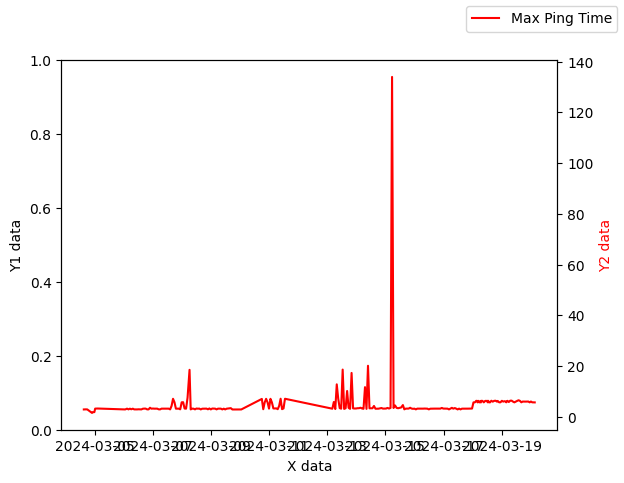

In [7]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
#ax1.plot(fTime, minPT,color='k',linestyle=':',label='Min Ping Time')
#ax1.plot(fTime, meanPT,color='k', label='Mean Ping Time')
ax2.plot(fTime, maxPT,color='r', label='Max Ping Time')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='k')
ax2.set_ylabel('Y2 data', color='r')

fig.legend(ncols=3)

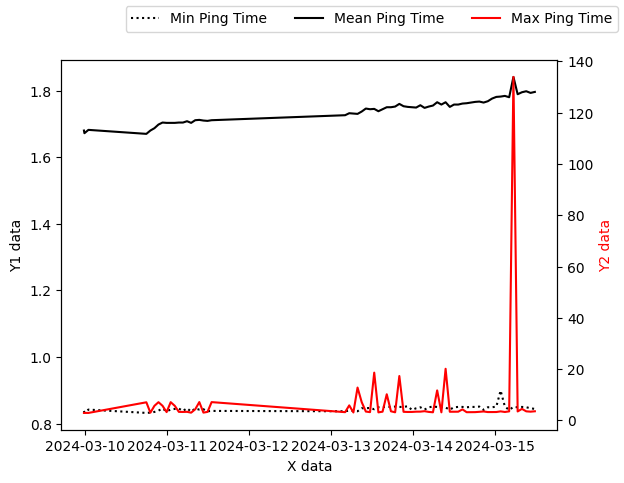

In [22]:

fig, ax1 = plt.subplots()
start=86
end=152

ax2 = ax1.twinx()
ax1.plot(fTime[start:end], minPT[start:end],color='k',linestyle=':',label='Min Ping Time')
ax1.plot(fTime[start:end], meanPT[start:end],color='k', label='Mean Ping Time')
ax2.plot(fTime[start:end], maxPT[start:end],color='r', label='Max Ping Time')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='k')
ax2.set_ylabel('Y2 data', color='r')

fig.legend(ncols=3)

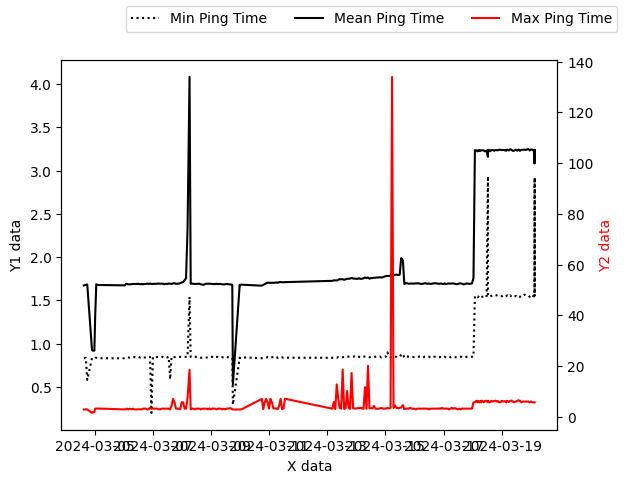

In [9]:

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(fTime, minPT,color='k',linestyle=':',label='Min Ping Time')
ax1.plot(fTime, meanPT,color='k', label='Mean Ping Time')
ax2.plot(fTime, maxPT,color='r', label='Max Ping Time')

ax1.set_xlabel('X data')
ax1.set_ylabel('Y1 data', color='k')
ax2.set_ylabel('Y2 data', color='r')

fig.legend(ncols=3)